In [1]:
from numpy import *
from scipy import *
import numpy as np
from matplotlib import *

from scipy import integrate
from scipy import interpolate
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

import xlrd
import xlsxwriter

rc('text',usetex = True)
rc('font', family='serif',size = 12)

In [2]:
Data = xlrd.open_workbook('AMR_Inputs.xlsx')
Eff = Data.sheet_by_name('Eff')


Effect = []

for i in range(7):
     Effect.append(array(Eff.col_values(i)))

phi = np.arange(0.1,2.01,0.1)
NTU = np.arange(50,351,50)
NN,PP = np.meshgrid(NTU,phi)
Effectiv = interpolate.interp2d(phi,NTU,Effect,kind = 'linear')

In [3]:
Data = xlrd.open_workbook('AMR_Inputs.xlsx')
HEx = Data.sheet_by_name('HEx_Cold')

m_f_HEx_c   = array(HEx.col_values(0)) 
Ec_HEx_c   = array(HEx.col_values(1)) 
W_T_HEx_c   = array(HEx.col_values(2)) 
W_f_HEx_c   = array(HEx.col_values(3)) 
W_p_HEx_c   = array(HEx.col_values(4)) 

In [4]:
Data = xlrd.open_workbook('AMR_Inputs.xlsx')
HEx = Data.sheet_by_name('HEx_Hot')

m_f_HEx_h   = array(HEx.col_values(0)) 
Ec_HEx_h   = array(HEx.col_values(1)) 
W_T_HEx_h   = array(HEx.col_values(2)) 
W_f_HEx_h   = array(HEx.col_values(3)) 
W_p_HEx_h   = array(HEx.col_values(4)) 

In [6]:
def HEx_Power(m_f_HEx,W_T_HEx,W_f_HEx,W_p_HEx,Ec_HEx,m_f,ECr):
    A = 0
    B = 9
    
    for i in range(len(m_f_HEx)-1):
        if np.round(m_f,4) == np.round(m_f_HEx[i],4) and np.round(m_f,4) < np.round(m_f_HEx[i+1],4):
            B = i
            #print(B)
            break
    #print(B,m_f,m_f_HEx[B],m_f_HEx[B+1])
    for i in range(B,0,-1):
        if m_f_HEx[i] == m_f_HEx[B]:
            A = i
        else:
            break
    #print(A,B,m_f_HEx[A],m_f_HEx[B])
    C = len(Ec_HEx)-1
    D = len(Ec_HEx)-1
    for i in range(A,B):
        #print(i,C)
        if abs(ECr-Ec_HEx[i]) < abs(ECr-Ec_HEx[C]) and ECr < Ec_HEx[i]:
            C = i
            #print('oic',C)
    for i in range(B,A,-1):
        #print(i,D)
        if abs(ECr-Ec_HEx[i]) < abs(ECr-Ec_HEx[D]) and ECr > Ec_HEx[i]:
            D = i
            #print('oid',D)
    #print(C,D,Ec_HEx[C],Ec_HEx[D])
    W_T = W_T_HEx[C]+(W_T_HEx[D]-W_T_HEx[C])*(ECr - Ec_HEx[C])/(Ec_HEx[D] - Ec_HEx[C])
    W_f = W_f_HEx[C]+(W_f_HEx[D]-W_f_HEx[C])*(ECr - Ec_HEx[C])/(Ec_HEx[D] - Ec_HEx[C])
    W_p = W_p_HEx[C]+(W_p_HEx[D]-W_p_HEx[C])*(ECr - Ec_HEx[C])/(Ec_HEx[D] - Ec_HEx[C])          
    return(W_T,W_f,W_p)

In [7]:
def Radius(X): 
    R2,R3,B = X
    return (1.41634776*(R2**-1.10684344)*(R3**2.08169412)*(B**0.74232364))

In [8]:
def Qc(X): 
    P1,P2,P3,P4,P5= X #Q_pas_CB,Q_act_CB,Q_span,W_mag,W_p
    return (0.5124256*P1+0.573295*P2-0.52893772*P3-0.00821663*P4-1.2800057*P5)

In [9]:
def Qh(X): 
    P1,P2,P3,P4,P5= X
    return (0.7308924*P1+1.31973655*P2-0.7599739*P3+0.01339801*P4-0.85528785*P5)

In [10]:
def W_Hex(X):
    P1,P2 = X
    return (a*P1**b + c*P2**d)

In [11]:
def Prop_param(X):
    T_c,T_h,B = X
    C_H = 1.65161038/100*T_c+2.59946197*T_h-1.14324309*100*B
    C_L = 10.16443738*T_c-5.32568341*T_h-0.71305997*B
    dT_mg = -0.01057708*T_c+0.01163704*T_h+1.73509682*B
    dT_dmg = -0.01229483*T_c+0.01376157*T_h+0.76454655*B
    CdT_mg = -9.517569*T_c+11.49711993*T_h+820.04168503*B
    CdT_dmg = 4.39480124*T_c-7.07931118/10*T_h+9.15928168*100*B
    return(C_H,C_L,dT_mg,dT_dmg,CdT_mg,CdT_dmg)

In [12]:
Data = xlrd.open_workbook('AMR_Inputs.xlsx') #Import inputs File
Inputs = Data.sheet_by_name('Data') 

L   = array(Inputs.col_values(0)) #Import AMR Length [mm]
H   = array(Inputs.col_values(1)) #Import AMR Height [mm]
W   = array(Inputs.col_values(2)) #Import AMR Width [mm]
T_c = array(Inputs.col_values(3))+273.15 #Import temperature span [K]
T_h = array(Inputs.col_values(4))+273.15 #Import temperature span [K]
B   = array(Inputs.col_values(5)) #Import magnetic field [T]
f   = array(Inputs.col_values(6)) #Import frequency [Hz]
m_f = array(Inputs.col_values(7))/3600 #Import mass flow rate [kg/h]
Q_c = array(Inputs.col_values(8)) #Import Cooling capacity [W]
Q_h = array(Inputs.col_values(9)) #Import Rejected heat [W]
W_p = array(Inputs.col_values(10)) #Import Pumping power [W]
W_m = array(Inputs.col_values(11)) #Import Magnetic power [W]
T_c_ml = array(Inputs.col_values(12))+273.15 #Import temperature span [K]
T_h_ml = array(Inputs.col_values(13))+273.15 #Import temperature span [K]

Calculation

In [13]:
def Optimal(m_f,FE,f,L,H,W,B,Tc,Th,Tce,The):
    
    ##Properties of the solid 
    rho_s = 7900  #[kg/m3] Density of the solid
    k_s   = 8 #[W/(m2.K)] #Thermal conductivity of the solid

    ## Propertis of the fluid
    rho_f = 1000  #[kg/m3] Density of the fluid
    c_f   = 4181  #[kJ/(kg.K)] # Specific heat of the fluid
    Pr_f  = 6.136 #[-] Prandtl of the fluid
    mu_f  = 0.00061 #0.0008901 #[kg/m-2] #Viscosity of the fluid
    k_f   = 0.6065  #[W/(m2.K)] #Thermal conductivity of the fluid

    ## Porous medium
    d_p = 500*10**(-6) #[m] Particle diameter
    Epsilon = 0.45  #[-] Porosity

    #Magnetic Circuit
    B_rem = 1.35
    N_p = 2
    N_Rp = 2
    
    ### CALCULATION ###
    
    #Porous medium
    m_s   = L*W*H*10**-9*(1-Epsilon)*rho_s #mass of the AMR
    Beta = (1-Epsilon)*6/d_p
    v_s   = (m_f)/(rho_f*W*H*10**-6) #Superficial velocity

    #Dimensionless Numbers
    Re_dp = d_p*v_s*rho_f/((1-Epsilon)*mu_f) #Reynolds number
    Nu = 2*(1+4*(1-Epsilon)/Epsilon)+((1-Epsilon)**0.5)*Re_dp**0.6*Pr_f**(1/3) # Nusselt number
    Pe = Re_dp*Pr_f
    h_int = Nu*k_f/d_p
    NTU_f  = h_int*Beta*(L*W*H*10**(-9))/(m_f*c_f) 
    dP = (L/1000)*(150*(1-Epsilon)**2*mu_f*v_s/(Epsilon**3*d_p**2) + 1.75*(1-Epsilon)*rho_f*v_s**2/(Epsilon**3*d_p))

    #Effective conduction
    k_e_f = k_f*Epsilon #Fluid effective conduction

    a_0 = exp(-1.084-6.778*(Epsilon-0.298))
    f_0 = 0.8
    k_e_s = k_f*((1-a_0)*(Epsilon*f_0+(1-Epsilon*f_0)*k_s/k_f)/(1-Epsilon*(1-f_0)+k_s/k_f*Epsilon*(1-f_0))+a_0*(2*((k_s/k_f)**2)*(1-Epsilon)+(1+2*Epsilon)*k_s/k_f)/((2+Epsilon)*k_s/k_f+(1-Epsilon))) #Solid effective conduction

    D_ = (k_f*rho_f/c_f)*0.75*Pe/2

    k_s_eff = k_e_s
    k_f_eff = k_e_f + rho_f*c_f*D_
    
    ##### Properties Calculation ######   
    C_H,C_L,dT_mg,dT_dmg,CdT_mg,CdT_dmg = Prop_param((Tce,The,B))

    ##### Porous media effectivness #####

    C_HB = ((m_f)*c_f)/(m_s*C_L*f)
    C_CB = ((m_f)*c_f)/(m_s*C_H*f)

    Efness_HB = Effectiv(C_HB/2,NTU_f)
    Efness_CB = Effectiv(C_CB/2,NTU_f)

    #print(Efness_HB,Efness_CB,h_int,Nu,v_s,Re_dp)


    ## Metrics ##

    Q_pas_CB = Efness_CB*(The - Tce)*m_f*FE*c_f
    Q_act_CB = dT_mg*m_f*c_f*FE

    Q_pas_HB = Efness_HB*(The - Tce)*m_f*FE*c_f
    Q_act_HB = dT_dmg*m_f*c_f*FE

    Q_span = (The - Tce)*m_f*c_f*FE
    Q_cond = ((1-Epsilon)*k_s_eff + Epsilon*k_f_eff)*(W*H*10**-6)*(The-Tce)/L
    W_mag  = m_s*f*(CdT_mg - CdT_dmg)
    W_pump = dP*m_f/rho_f*2*(FE)
    #print(Q_pas_CB,Q_act_CB,Q_span,W_mag,W_pump)

    ######Calculation#######
    
    N_reg = 4/FE

    Qc_reg = Qc((Q_pas_CB,Q_act_CB,Q_span,W_mag,W_pump))
    Qh_reg = Qh((Q_pas_HB,Q_act_HB,Q_span,W_mag,W_pump))

    #N_reg = Qc_target/Qc_reg
    Qc_target = Qc_reg*N_reg 
    Qh_target = Qh_reg*N_reg

    ECr_c = Qc_target/(FE*N_reg*m_f*c_f*(Tc-Tce))
    ECr_h = Qh_target/(FE*N_reg*m_f*c_f*(The-Th))
    
    B_rem = 1.35
    
    R2 = [W/2+2.5]/np.tan(np.pi/N_reg)
    R_aux = np.sqrt(R2**2-(W/2**2))
    R3 = np.sqrt((H+8+R_aux)**2+(W/2)**2)
    R4 = Radius((R2,R3,1.1*B/B_rem))
    
    W_mag = Qh_reg - Qc_reg - W_pump
    
    
    return (Qc_target,ECr_c,ECr_h,R4,R3,R2,W_mag,W_pump,Qh_target)

In [14]:
Qc_rg = []
Qh_rg = []
W_pump_rg =[]
ECr_c = []
ECr_h = []
N_r = []
R2 = []
R3 = []
R4 = []

for i in range(len(L)):                          
    A1,A2,A3,A4,A5,A6,A7,A8,A9 = Optimal(m_f[i],0.25,f[i],L[i],H[i],W[i],B[i],22+273.15,35+273.15,T_c[i],T_h[i])
    Qc_rg.append(A1)
    Qh_rg.append(A9)
    W_pump_rg.append(A8)
    ECr_c.append(A2)
    ECr_h.append(A3)
    N_r.append(A6)
    R2.append(A6)
    R3.append(A5)
    R4.append(A4)

In [15]:
m_f = np.arange(450,801,5)/3600
FE  = np.arange(25/100,30/100,5/100) 
f = np.arange(1,1.51,0.1)
L = np.arange(140,161,10)
H = np.arange(20,36,5)
W = np.arange(45,61,5)
B_max = np.arange(1.2,1.31,0.05)
Tce = np.arange(10,15,2)
The = np.arange(43,48,2)

In [16]:
len(FE)*len(f)*len(L)*len(H)*len(W)*len(Tce)*len(The)*len(B_max)

7776

In [17]:
Q_c = []
cont = 0

T_c = 22
T_h = 35

Q_c_target = 2900

m_f_target = []
FE_target = []
f_target = []
L_target = []
H_target = []
W_target = []
Tce_target = []
The_target = []
ECr_c = []
ECr_h = []
R4 = []
R3 = []
R2 = []
W_mag = []
W_pump = []
B_target = []
Q_h = []

for i in range(size(FE)):
    for j in range(len(f)):
        for k in range(len(L)):
            for l in range(len(H)):
                for m in range(len(W)):
                    for n in range(len(Tce)):
                        for o in range(len(The)):
                            for p in range(len(B_max)):
                                it = 0
                                Q_c_system = 0
                                while Q_c_system < Q_c_target and it < len(m_f):
                                    A,B,C,D,E,F,G,A1,A2 = Optimal(m_f[it],FE[i],f[j],L[k],H[l],W[m],B_max[p],T_c+273.15,T_h+273.15,Tce[n]+273.15,The[o]+273.15)
                                    Q_c_system = A[0]
                                    it = it + 1
                                #print(it,Q_c_system)
                                if Q_c_system > Q_c_target:
                                    Q_c.append(Q_c_system)
                                    m_f_target.append(3600*m_f[it-1])
                                    FE_target.append(FE[i])
                                    f_target.append(f[j])
                                    L_target.append(L[k])
                                    H_target.append(H[l])
                                    W_target.append(W[m])
                                    Tce_target.append(Tce[n])
                                    The_target.append(The[o])
                                    B_target.append(B_max[p])
                                    ECr_c.append(B[0])
                                    ECr_h.append(C[0])
                                    R4.append(D[0])
                                    R3.append(E[0])
                                    R2.append(F[0])
                                    W_mag.append(G[0])
                                    W_pump.append(A1)
                                    Q_h.append(A2[0])

                                cont = cont+1
                                print(100*cont/(len(FE)*len(f)*len(L)*len(H)*len(W)*len(Tce)*len(The)*len(B_max)))
                            

0.01286008230452675
0.0257201646090535
0.038580246913580245
0.051440329218107
0.06430041152263374
0.07716049382716049
0.09002057613168725
0.102880658436214
0.11574074074074074
0.1286008230452675
0.14146090534979425
0.15432098765432098
0.16718106995884774
0.1800411522633745
0.19290123456790123
0.205761316872428
0.21862139917695472
0.23148148148148148
0.24434156378600824
0.257201646090535
0.2700617283950617
0.2829218106995885
0.2957818930041152
0.30864197530864196
0.32150205761316875
0.3343621399176955
0.3472222222222222
0.360082304526749
0.37294238683127573
0.38580246913580246
0.3986625514403292
0.411522633744856
0.4243827160493827
0.43724279835390945
0.45010288065843623
0.46296296296296297
0.4758230452674897
0.4886831275720165
0.5015432098765432
0.51440329218107
0.5272633744855967
0.5401234567901234
0.5529835390946503
0.565843621399177
0.5787037037037037
0.5915637860082305
0.6044238683127572
0.6172839506172839
0.6301440329218106
0.6430041152263375
0.6558641975308642
0.668724279835391
0

5.941358024691358
5.954218106995885
5.967078189300412
5.979938271604938
5.992798353909465
6.0056584362139915
6.018518518518518
6.031378600823046
6.044238683127572
6.057098765432099
6.0699588477366255
6.082818930041152
6.095679012345679
6.108539094650205
6.121399176954733
6.1342592592592595
6.147119341563786
6.159979423868313
6.172839506172839
6.185699588477366
6.198559670781893
6.21141975308642
6.224279835390947
6.237139917695473
6.25
6.262860082304527
6.275720164609053
6.28858024691358
6.301440329218107
6.314300411522634
6.327160493827161
6.340020576131687
6.352880658436214
6.3657407407407405
6.378600823045267
6.391460905349795
6.404320987654321
6.417181069958848
6.4300411522633745
6.442901234567901
6.455761316872428
6.468621399176954
6.481481481481482
6.4943415637860085
6.507201646090535
6.520061728395062
6.532921810699588
6.545781893004115
6.558641975308642
6.571502057613169
6.584362139917696
6.597222222222222
6.610082304526749
6.622942386831276
6.635802469135802
6.648662551440329
6

11.959876543209877
11.972736625514404
11.98559670781893
11.998456790123457
12.011316872427983
12.02417695473251
12.037037037037036
12.049897119341564
12.062757201646091
12.075617283950617
12.088477366255145
12.10133744855967
12.114197530864198
12.127057613168724
12.139917695473251
12.152777777777779
12.165637860082304
12.178497942386832
12.191358024691358
12.204218106995885
12.21707818930041
12.229938271604938
12.242798353909466
12.255658436213992
12.268518518518519
12.281378600823045
12.294238683127572
12.307098765432098
12.319958847736626
12.332818930041153
12.345679012345679
12.358539094650206
12.371399176954732
12.38425925925926
12.397119341563785
12.409979423868313
12.42283950617284
12.435699588477366
12.448559670781894
12.46141975308642
12.474279835390947
12.487139917695472
12.5
12.512860082304528
12.525720164609053
12.53858024691358
12.551440329218106
12.564300411522634
12.57716049382716
12.590020576131687
12.602880658436215
12.61574074074074
12.628600823045268
12.64146090534979

17.68261316872428
17.695473251028808
17.708333333333332
17.72119341563786
17.734053497942387
17.746913580246915
17.75977366255144
17.772633744855966
17.785493827160494
17.79835390946502
17.81121399176955
17.824074074074073
17.8369341563786
17.849794238683128
17.862654320987655
17.875514403292183
17.888374485596707
17.901234567901234
17.91409465020576
17.92695473251029
17.939814814814813
17.95267489711934
17.965534979423868
17.978395061728396
17.991255144032923
18.004115226337447
18.016975308641975
18.029835390946502
18.04269547325103
18.055555555555557
18.06841563786008
18.08127572016461
18.094135802469136
18.106995884773664
18.119855967078188
18.132716049382715
18.145576131687243
18.15843621399177
18.171296296296298
18.18415637860082
18.19701646090535
18.209876543209877
18.222736625514404
18.23559670781893
18.248456790123456
18.261316872427983
18.27417695473251
18.287037037037038
18.299897119341562
18.31275720164609
18.325617283950617
18.338477366255145
18.351337448559672
18.364197530

23.431069958847736
23.443930041152264
23.45679012345679
23.469650205761315
23.482510288065843
23.49537037037037
23.508230452674898
23.521090534979425
23.53395061728395
23.546810699588477
23.559670781893004
23.57253086419753
23.58539094650206
23.598251028806583
23.61111111111111
23.62397119341564
23.636831275720166
23.64969135802469
23.662551440329217
23.675411522633745
23.688271604938272
23.7011316872428
23.713991769547324
23.72685185185185
23.73971193415638
23.752572016460906
23.765432098765434
23.778292181069958
23.791152263374485
23.804012345679013
23.81687242798354
23.829732510288064
23.84259259259259
23.85545267489712
23.868312757201647
23.881172839506174
23.894032921810698
23.906893004115226
23.919753086419753
23.93261316872428
23.945473251028808
23.958333333333332
23.97119341563786
23.984053497942387
23.996913580246915
24.00977366255144
24.022633744855966
24.035493827160494
24.04835390946502
24.06121399176955
24.074074074074073
24.0869341563786
24.099794238683128
24.112654320987

29.15380658436214
29.166666666666668
29.179526748971192
29.19238683127572
29.205246913580247
29.218106995884774
29.230967078189302
29.243827160493826
29.256687242798353
29.26954732510288
29.28240740740741
29.295267489711936
29.30812757201646
29.320987654320987
29.333847736625515
29.346707818930042
29.359567901234566
29.372427983539094
29.38528806584362
29.39814814814815
29.411008230452676
29.4238683127572
29.436728395061728
29.449588477366255
29.462448559670783
29.47530864197531
29.488168724279834
29.50102880658436
29.51388888888889
29.526748971193417
29.53960905349794
29.55246913580247
29.565329218106996
29.578189300411523
29.59104938271605
29.603909465020575
29.616769547325102
29.62962962962963
29.642489711934157
29.655349794238685
29.66820987654321
29.681069958847736
29.693930041152264
29.70679012345679
29.719650205761315
29.732510288065843
29.74537037037037
29.758230452674898
29.771090534979425
29.78395061728395
29.796810699588477
29.809670781893004
29.82253086419753
29.83539094650

34.88940329218107
34.9022633744856
34.91512345679013
34.92798353909465
34.940843621399175
34.9537037037037
34.96656378600823
34.97942386831276
34.992283950617285
35.00514403292181
35.01800411522634
35.03086419753087
35.04372427983539
35.056584362139915
35.06944444444444
35.08230452674897
35.0951646090535
35.108024691358025
35.12088477366255
35.13374485596708
35.14660493827161
35.15946502057613
35.172325102880656
35.18518518518518
35.19804526748971
35.21090534979424
35.223765432098766
35.23662551440329
35.24948559670782
35.26234567901235
35.275205761316876
35.288065843621396
35.300925925925924
35.31378600823045
35.32664609053498
35.339506172839506
35.352366255144034
35.36522633744856
35.37808641975309
35.390946502057616
35.40380658436214
35.416666666666664
35.42952674897119
35.44238683127572
35.45524691358025
35.468106995884774
35.4809670781893
35.49382716049383
35.50668724279836
35.51954732510288
35.532407407407405
35.54526748971193
35.55812757201646
35.57098765432099
35.58384773662551

40.77932098765432
40.79218106995885
40.80504115226338
40.8179012345679
40.830761316872426
40.84362139917695
40.85648148148148
40.86934156378601
40.882201646090536
40.89506172839506
40.90792181069959
40.92078189300412
40.93364197530864
40.946502057613166
40.959362139917694
40.97222222222222
40.98508230452675
40.99794238683128
41.010802469135804
41.02366255144033
41.03652263374486
41.04938271604938
41.06224279835391
41.075102880658434
41.08796296296296
41.10082304526749
41.11368312757202
41.126543209876544
41.13940329218107
41.1522633744856
41.16512345679013
41.17798353909465
41.190843621399175
41.2037037037037
41.21656378600823
41.22942386831276
41.242283950617285
41.25514403292181
41.26800411522634
41.28086419753087
41.29372427983539
41.306584362139915
41.31944444444444
41.33230452674897
41.3451646090535
41.358024691358025
41.37088477366255
41.38374485596708
41.39660493827161
41.40946502057613
41.422325102880656
41.43518518518518
41.44804526748971
41.46090534979424
41.473765432098766
4

46.59207818930041
46.60493827160494
46.617798353909464
46.63065843621399
46.64351851851852
46.65637860082305
46.669238683127574
46.6820987654321
46.69495884773662
46.70781893004115
46.72067901234568
46.733539094650205
46.74639917695473
46.75925925925926
46.77211934156379
46.784979423868315
46.79783950617284
46.81069958847737
46.82355967078189
46.83641975308642
46.849279835390945
46.86213991769547
46.875
46.88786008230453
46.900720164609055
46.91358024691358
46.92644032921811
46.93930041152263
46.95216049382716
46.965020576131685
46.97788065843621
46.99074074074074
47.00360082304527
47.016460905349795
47.02932098765432
47.04218106995885
47.05504115226338
47.0679012345679
47.080761316872426
47.09362139917695
47.10648148148148
47.11934156378601
47.132201646090536
47.14506172839506
47.15792181069959
47.17078189300412
47.18364197530864
47.196502057613166
47.209362139917694
47.22222222222222
47.23508230452675
47.24794238683128
47.260802469135804
47.27366255144033
47.28652263374486
47.2993827

52.48199588477366
52.49485596707819
52.507716049382715
52.52057613168724
52.53343621399177
52.5462962962963
52.559156378600825
52.57201646090535
52.58487654320987
52.5977366255144
52.61059670781893
52.623456790123456
52.63631687242798
52.64917695473251
52.66203703703704
52.674897119341566
52.68775720164609
52.70061728395062
52.71347736625514
52.72633744855967
52.739197530864196
52.75205761316872
52.76491769547325
52.77777777777778
52.790637860082306
52.803497942386834
52.81635802469136
52.82921810699588
52.84207818930041
52.85493827160494
52.867798353909464
52.88065843621399
52.89351851851852
52.90637860082305
52.919238683127574
52.9320987654321
52.94495884773662
52.95781893004115
52.97067901234568
52.983539094650205
52.99639917695473
53.00925925925926
53.02211934156379
53.034979423868315
53.04783950617284
53.06069958847737
53.07355967078189
53.08641975308642
53.099279835390945
53.11213991769547
53.125
53.13786008230453
53.150720164609055
53.16358024691358
53.17644032921811
53.18930041

58.34619341563786
58.359053497942384
58.37191358024691
58.38477366255144
58.397633744855966
58.410493827160494
58.42335390946502
58.43621399176955
58.449074074074076
58.461934156378604
58.474794238683124
58.48765432098765
58.50051440329218
58.51337448559671
58.526234567901234
58.53909465020576
58.55195473251029
58.56481481481482
58.577674897119344
58.59053497942387
58.60339506172839
58.61625514403292
58.62911522633745
58.641975308641975
58.6548353909465
58.66769547325103
58.68055555555556
58.693415637860085
58.70627572016461
58.71913580246913
58.73199588477366
58.74485596707819
58.757716049382715
58.77057613168724
58.78343621399177
58.7962962962963
58.809156378600825
58.82201646090535
58.83487654320987
58.8477366255144
58.86059670781893
58.873456790123456
58.88631687242798
58.89917695473251
58.91203703703704
58.924897119341566
58.93775720164609
58.95061728395062
58.96347736625514
58.97633744855967
58.989197530864196
59.00205761316872
59.01491769547325
59.02777777777778
59.0406378600823

64.22325102880659
64.23611111111111
64.24897119341564
64.26183127572017
64.2746913580247
64.28755144032922
64.30041152263375
64.31327160493827
64.32613168724279
64.33899176954732
64.35185185185185
64.36471193415638
64.3775720164609
64.39043209876543
64.40329218106996
64.41615226337449
64.42901234567901
64.44187242798354
64.45473251028807
64.4675925925926
64.48045267489712
64.49331275720165
64.50617283950618
64.5190329218107
64.53189300411523
64.54475308641975
64.55761316872427
64.5704732510288
64.58333333333333
64.59619341563786
64.60905349794238
64.62191358024691
64.63477366255144
64.64763374485597
64.6604938271605
64.67335390946502
64.68621399176955
64.69907407407408
64.7119341563786
64.72479423868313
64.73765432098766
64.75051440329219
64.76337448559671
64.77623456790124
64.78909465020575
64.80195473251028
64.81481481481481
64.82767489711934
64.84053497942386
64.85339506172839
64.86625514403292
64.87911522633745
64.89197530864197
64.9048353909465
64.91769547325103
64.93055555555556


70.22890946502058
70.2417695473251
70.25462962962963
70.26748971193416
70.28034979423869
70.29320987654322
70.30606995884774
70.31893004115226
70.33179012345678
70.34465020576131
70.35751028806584
70.37037037037037
70.3832304526749
70.39609053497942
70.40895061728395
70.42181069958848
70.434670781893
70.44753086419753
70.46039094650206
70.47325102880659
70.48611111111111
70.49897119341564
70.51183127572017
70.5246913580247
70.53755144032922
70.55041152263375
70.56327160493827
70.57613168724279
70.58899176954732
70.60185185185185
70.61471193415638
70.6275720164609
70.64043209876543
70.65329218106996
70.66615226337449
70.67901234567901
70.69187242798354
70.70473251028807
70.7175925925926
70.73045267489712
70.74331275720165
70.75617283950618
70.7690329218107
70.78189300411523
70.79475308641975
70.80761316872427
70.8204732510288
70.83333333333333
70.84619341563786
70.85905349794238
70.87191358024691
70.88477366255144
70.89763374485597
70.9104938271605
70.92335390946502
70.93621399176955
70

76.42746913580247
76.440329218107
76.45318930041152
76.46604938271605
76.47890946502058
76.4917695473251
76.50462962962963
76.51748971193416
76.53034979423869
76.54320987654322
76.55606995884774
76.56893004115226
76.58179012345678
76.59465020576131
76.60751028806584
76.62037037037037
76.6332304526749
76.64609053497942
76.65895061728395
76.67181069958848
76.684670781893
76.69753086419753
76.71039094650206
76.72325102880659
76.73611111111111
76.74897119341564
76.76183127572017
76.7746913580247
76.78755144032922
76.80041152263375
76.81327160493827
76.82613168724279
76.83899176954732
76.85185185185185
76.86471193415638
76.8775720164609
76.89043209876543
76.90329218106996
76.91615226337449
76.92901234567901
76.94187242798354
76.95473251028807
76.9675925925926
76.98045267489712
76.99331275720165
77.00617283950618
77.0190329218107
77.03189300411523
77.04475308641975
77.05761316872427
77.0704732510288
77.08333333333333
77.09619341563786
77.10905349794238
77.12191358024691
77.13477366255144
77.

82.45884773662551
82.47170781893004
82.48456790123457
82.4974279835391
82.51028806584362
82.52314814814815
82.53600823045268
82.54886831275721
82.56172839506173
82.57458847736625
82.58744855967078
82.6003086419753
82.61316872427983
82.62602880658436
82.63888888888889
82.65174897119341
82.66460905349794
82.67746913580247
82.690329218107
82.70318930041152
82.71604938271605
82.72890946502058
82.7417695473251
82.75462962962963
82.76748971193416
82.78034979423869
82.79320987654322
82.80606995884774
82.81893004115226
82.83179012345678
82.84465020576131
82.85751028806584
82.87037037037037
82.8832304526749
82.89609053497942
82.90895061728395
82.92181069958848
82.934670781893
82.94753086419753
82.96039094650206
82.97325102880659
82.98611111111111
82.99897119341564
83.01183127572017
83.0246913580247
83.03755144032922
83.05041152263375
83.06327160493827
83.07613168724279
83.08899176954732
83.10185185185185
83.11471193415638
83.1275720164609
83.14043209876543
83.15329218106996
83.16615226337449
83

88.40020576131687
88.4130658436214
88.42592592592592
88.43878600823045
88.45164609053498
88.4645061728395
88.47736625514403
88.49022633744856
88.50308641975309
88.51594650205762
88.52880658436214
88.54166666666667
88.5545267489712
88.56738683127573
88.58024691358025
88.59310699588477
88.6059670781893
88.61882716049382
88.63168724279835
88.64454732510288
88.6574074074074
88.67026748971193
88.68312757201646
88.69598765432099
88.70884773662551
88.72170781893004
88.73456790123457
88.7474279835391
88.76028806584362
88.77314814814815
88.78600823045268
88.79886831275721
88.81172839506173
88.82458847736625
88.83744855967078
88.8503086419753
88.86316872427983
88.87602880658436
88.88888888888889
88.90174897119341
88.91460905349794
88.92746913580247
88.940329218107
88.95318930041152
88.96604938271605
88.97890946502058
88.9917695473251
89.00462962962963
89.01748971193416
89.03034979423869
89.04320987654322
89.05606995884774
89.06893004115226
89.08179012345678
89.09465020576131
89.10751028806584
89

94.31584362139918
94.32870370370371
94.34156378600824
94.35442386831275
94.36728395061728
94.3801440329218
94.39300411522633
94.40586419753086
94.41872427983539
94.43158436213992
94.44444444444444
94.45730452674897
94.4701646090535
94.48302469135803
94.49588477366255
94.50874485596708
94.52160493827161
94.53446502057614
94.54732510288066
94.56018518518519
94.57304526748972
94.58590534979425
94.59876543209876
94.61162551440329
94.62448559670781
94.63734567901234
94.65020576131687
94.6630658436214
94.67592592592592
94.68878600823045
94.70164609053498
94.7145061728395
94.72736625514403
94.74022633744856
94.75308641975309
94.76594650205762
94.77880658436214
94.79166666666667
94.8045267489712
94.81738683127573
94.83024691358025
94.84310699588477
94.8559670781893
94.86882716049382
94.88168724279835
94.89454732510288
94.9074074074074
94.92026748971193
94.93312757201646
94.94598765432099
94.95884773662551
94.97170781893004
94.98456790123457
94.9974279835391
95.01028806584362
95.02314814814815


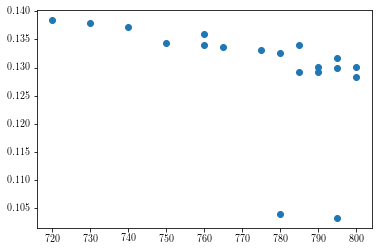

In [18]:
plt.plot(m_f_target,np.array(ECr_h),'o')

for i in range(len(m_f_target)):
    if isnan(W_FT_c[i]) == True:
        print(i)

In [22]:
N_circ_cold = 6
N_circ_hot = 8

W_FT_c = np.zeros(len(m_f_target))
W_Ff_c = np.zeros(len(m_f_target))
W_Fp_c = np.zeros(len(m_f_target))

W_FT_h = np.zeros(len(m_f_target))
W_Ff_h = np.zeros(len(m_f_target))
W_Fp_h = np.zeros(len(m_f_target))


for i in range(len(m_f_target)):
    [W_FT_c[i],W_Ff_c[i],W_Fp_c[i]] = HEx_Power(m_f_HEx_c,W_T_HEx_c,W_f_HEx_c,W_p_HEx_c,Ec_HEx_c,4*m_f_target[i]/N_circ_cold,ECr_c[i])
    [W_FT_h[i],W_Ff_h[i],W_Fp_h[i]] = HEx_Power(m_f_HEx_h,W_T_HEx_h,W_f_HEx_h,W_p_HEx_h,Ec_HEx_h,4*m_f_target[i]/N_circ_hot,ECr_h[i])
    #if W_FT_c[i] == 'Nan':
        #print(4*m_f_target[i]/8,ECr_c[i])
    #if W_FT_c[i] == 'Nan':
        #print(4*m_f_target[i]/8,ECr_h[i])

In [23]:
W_p_valve = (2*np.array(m_f_target)/4/1000)**2*10**5**(2*np.array(m_f_target)/3600)/1000*4/np.array(FE_target)
W_valve   = 8*16

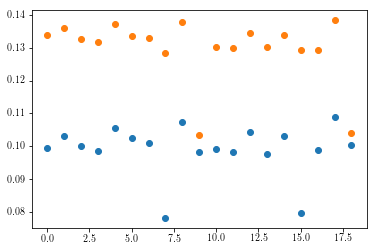

In [24]:
plt.plot(ECr_c,'o')
plt.plot(ECr_h,'o')

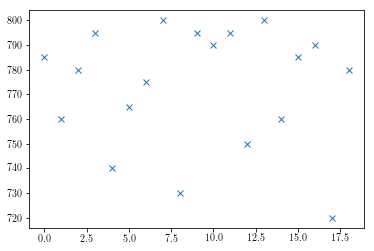

In [25]:
plt.plot(m_f_target,'x')

In [26]:
m_La = 4/np.array(FE_target)*np.array(H_target)*np.array(W_target)*np.array(L_target)*(1-0.45)*7000*10**-9
m_Rt = np.pi*((np.array(R4))**2-np.array(R3)**2)*10**-6*(1.3*np.array(L_target)/1000)*7500 #25**2
m_St = np.pi*((np.array(R2)**2))*10**-6*(1.3*np.array(L_target)/1000)*7500
m_Fe = np.pi*((np.array(R4)+40)**2-np.array(R4)**2)*10**-6*(1.3*np.array(L_target)/1000)*7500 #25**2
m_Nd = m_Rt + m_St + m_Fe
m_w  = (4/np.array(FE_target)*np.array(H_target)*np.array(W_target)*np.array(L_target)*(0.45)*1000*10**-9)

In [27]:
m_T = m_La + m_Rt + m_St + m_Fe + m_w
W_T = W_Ff_c + W_Ff_h + W_Fp_c + W_Fp_h +np.array(W_mag)*4/np.array(FE_target) + np.array(W_pump)*4/np.array(FE_target) + W_valve + W_p_valve

In [28]:
m_p = []
W_pa =[]

m_Nd_p = []
m_La_p = []
m_w_p = []

W_p_CHEx_p = []
W_p_CHEx_f = []
W_p_HHEx_p = []
W_p_HHEx_f = []
W_p_mag = []
W_p_pump = []
W_pa_valve = []
W_pa_p_valve = []


m_f_p = []
FE_p  =[]
f_p = []
L_p = []
H_p = []
W_p = []
B_max_p = []
Tce_p = []
The_p = []

R2_p = []
R3_p = []
R4_p = []


for i in range(len(m_T)):
    #print(i)
    A = 0
    for j in  range(len(m_T)):
        if m_T[i] >= m_T[j] and W_T[i] > W_T[j]:
            A = 1
    if A == 0 :
        #print(m_T[i],W_T[i])
        m_p.append(m_T[i])
        m_Nd_p.append(m_Nd[i])
        m_La_p.append(m_La[i])
        m_w_p.append(m_w[i])
        
        m_f_p.append(m_f_target[i])
        FE_p.append(FE_target[i])
        f_p.append(f_target[i])
        L_p.append(L_target[i])
        H_p.append(H_target[i])
        W_p.append(W_target[i])
        B_max_p.append(B_target[i])
        Tce_p.append(Tce_target[i])
        The_p.append(The_target[i])
        
        R2_p.append(R2[i])
        R3_p.append(R3[i])
        R4_p.append(R4[i])
        
        
        
        W_pa.append(W_T[i])
        W_p_CHEx_p.append(W_Fp_c[i])
        W_p_CHEx_f.append(W_Ff_c[i])
        W_p_HHEx_p.append(W_Fp_h[i])
        W_p_HHEx_f.append(W_Ff_h[i])
        W_p_mag.append(np.array(W_mag[i])*4/np.array(FE_target[i]))
        W_p_pump.append(np.array(W_pump[i])*4/np.array(FE_target[i]))
        W_pa_valve.append(W_valve)
        W_pa_p_valve.append(W_p_valve[i])   

Text(0,0.5,'Power [W]')

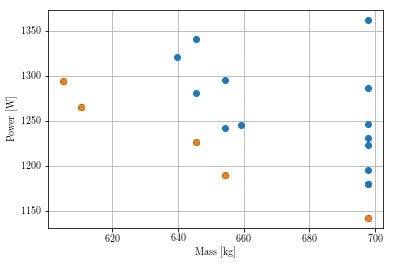

In [29]:
plt.plot(m_T,W_T,'o')
plt.plot(m_p,W_pa,'X')
plt.grid()
plt.xlabel('Mass [kg]')
plt.ylabel('Power [W]')
#plt.savefig('Optimum_2Hz.png',format = 'png', dpi=500,bbox_inches='tight')

In [30]:
m_W70 = m_p
W_W70 = W_pa

In [31]:
plt.plot(m_W55,W_W55,'o', label = 'W = 55 mm')
plt.plot(m_W60,W_W60,'o', label = 'W = 60 mm')
plt.plot(m_W70,W_W70,'o', label = 'W = 70 mm')

plt.grid()
plt.xlabel('Mass [kg]')
plt.ylabel('Power [W]')
plt.legend()
plt.savefig('Width.png',format = 'png', dpi=500,bbox_inches='tight')

NameError: name 'm_W55' is not defined

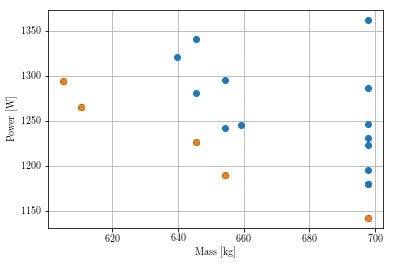

In [32]:
plt.plot(m_T,W_T,'o')
plt.plot(m_p,W_pa,'X')
plt.grid()
#plt.xlim([500,700])
#plt.ylim([1000,2500])
plt.xlabel('Mass [kg]')
plt.ylabel('Power [W]')
plt.savefig('Optimum_zoom_1Hz.png',format = 'png', dpi=500,bbox_inches='tight')

In [33]:
dP_AMR = np.array(W_pump)/(np.array(m_f_target)/3600)*1000

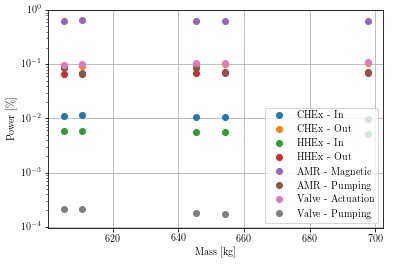

In [34]:
plt.semilogy(m_p,np.array(W_p_CHEx_p)/np.array(W_pa),'o',label = 'CHEx - In')
plt.semilogy(m_p,np.array(W_p_CHEx_f)/np.array(W_pa),'o',label = 'CHEx - Out')
plt.semilogy(m_p,np.array(W_p_HHEx_p)/np.array(W_pa),'o',label = 'HHEx - In')
plt.semilogy(m_p,np.array(W_p_HHEx_f)/np.array(W_pa),'o',label = 'HHEx - Out')
plt.semilogy(m_p,np.array(W_p_mag)/np.array(W_pa),'o',label = 'AMR - Magnetic')
plt.semilogy(m_p,np.array(W_p_pump)/np.array(W_pa),'o',label = 'AMR - Pumping')
plt.semilogy(m_p,np.array(W_pa_valve)/np.array(W_pa),'o',label = 'Valve - Actuation')
plt.semilogy(m_p,np.array(W_pa_p_valve)/np.array(W_pa),'o',label = 'Valve - Pumping')
plt.grid()
plt.xlabel('Mass [kg]')
plt.ylabel('Power [$\%$]')
plt.legend()
plt.savefig('Power_Breakdown.png',format = 'png', dpi=500,bbox_inches='tight')

In [35]:
workbook = xlsxwriter.Workbook('Optimization_results.xlsx')
Data = workbook.add_worksheet('Data')

for i in range(len(m_f_p)):
    Data.write(i,0,m_f_p[i]) 
    Data.write(i,1,FE_p[i])
    Data.write(i,2,f_p[i])
    Data.write(i,3,L_p[i])
    Data.write(i,4,H_p[i])
    Data.write(i,5,W_p[i]) 
    Data.write(i,6,B_max_p[i])
    Data.write(i,7,Tce_p[i])
    Data.write(i,8,The_p[i])
    Data.write(i,9,m_p[i])
    Data.write(i,10,m_Nd_p[i])
    Data.write(i,11,m_La_p[i])
    Data.write(i,12,m_w_p[i])
    Data.write(i,13,W_pa[i])
    Data.write(i,14,W_p_CHEx_p[i])
    Data.write(i,15,W_p_CHEx_f[i])
    Data.write(i,16,W_p_HHEx_p[i])
    Data.write(i,17,W_p_HHEx_f[i])
    Data.write(i,18,W_p_mag[i])
    Data.write(i,19,W_p_pump[i])
    Data.write(i,20,R2_p[i])
    Data.write(i,21,R3_p[i])
    Data.write(i,22,R4_p[i])
    

workbook.close()

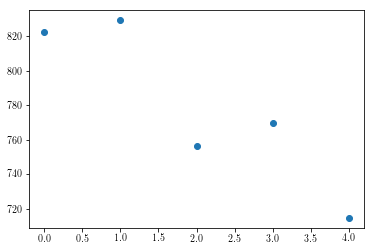

In [36]:
A = W_p_CHEx_f +W_p_CHEx_p
plt.plot(W_p_mag,'o')

In [37]:
W_pa

[1265.1046062343476,
 1294.8483652101359,
 1189.3197619751306,
 1226.9053567602482,
 1142.0445868194145]

In [38]:
len(W_p_valve)

19

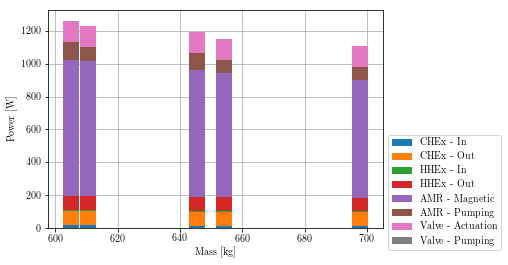

In [39]:
width = 5
plt.grid(zorder = 0)
plt.bar(m_p,W_p_CHEx_p, width, label = 'CHEx - In',zorder = 3)
plt.bar(m_p,W_p_HHEx_f, width, bottom = W_p_CHEx_p, label = 'CHEx - Out',zorder = 3)
plt.bar(m_p,W_p_HHEx_p, width, bottom = np.array(W_p_CHEx_p) + np.array(W_p_HHEx_f), label = 'HHEx - In',zorder = 3)
plt.bar(m_p,W_p_HHEx_f, width, bottom = np.array(W_p_CHEx_p) + np.array(W_p_HHEx_f)+ np.array(W_p_HHEx_p), label = 'HHEx - Out',zorder = 3)
plt.bar(m_p,W_p_mag, width, bottom = np.array(W_p_CHEx_p) + np.array(W_p_HHEx_f)+ np.array(W_p_HHEx_p)+ np.array(W_p_HHEx_f), label = 'AMR - Magnetic',zorder = 3)
plt.bar(m_p,W_p_pump, width, bottom = np.array(W_p_CHEx_p) + np.array(W_p_HHEx_f)+ np.array(W_p_HHEx_p)+ np.array(W_p_HHEx_f)+ np.array(W_p_mag) , label = 'AMR - Pumping',zorder = 3)
plt.bar(m_p,W_pa_valve, width, bottom = np.array(W_p_CHEx_p) + np.array(W_p_HHEx_f)+ np.array(W_p_HHEx_p)+ np.array(W_p_HHEx_f) + np.array(W_p_mag) + np.array(W_p_pump) , label = 'Valve - Actuation',zorder = 3)
plt.bar(m_p,W_pa_p_valve, width, bottom = np.array(W_p_CHEx_p) + np.array(W_p_HHEx_f)+ np.array(W_p_HHEx_p)+ np.array(W_p_HHEx_f)+ np.array(W_p_mag) + np.array(W_p_pump)+ np.array(W_pa_valve), label = 'Valve - Pumping',zorder = 3)

#plt.xlim([575,865])
plt.xlabel('Mass [kg]')
plt.ylabel('Power [W]')
plt.legend(bbox_to_anchor = (1,0.45))
plt.savefig('Power_Breakdown.png',format = 'png', dpi=500,bbox_inches='tight')

In [40]:
m_Rt_p = np.pi*((np.array(R4_p))**2-np.array(R3_p)**2)*10**-6*(1.3*np.array(L_p)/1000)*7500 #25**2
m_St_p = np.pi*((np.array(R2_p)**2))*10**-6*(1.3*np.array(L_p)/1000)*7500
m_Fe_p_10 = np.pi*((np.array(R4_p)+10)**2-np.array(R4_p)**2)*10**-6*(1.3*np.array(L_p)/1000)*7500 #25**2 
m_Fe_p_20 = np.pi*((np.array(R4_p)+20)**2-(np.array(R4_p)+10)**2)*10**-6*(1.3*np.array(L_p)/1000)*7500 #25**2 
m_Fe_p_40 = np.pi*((np.array(R4_p)+40)**2-(np.array(R4_p)+20)**2)*10**-6*(1.3*np.array(L_p)/1000)*7500 #25**2 
m_Fe_p_80 = np.pi*((np.array(R4_p)+80)**2-(np.array(R4_p)+40)**2)*10**-6*(1.3*np.array(L_p)/1000)*7500 #25**2 

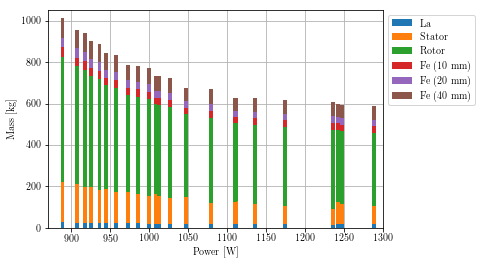

In [50]:
width = 5
plt.grid(zorder = 0)
plt.bar(W_pa,m_La_p, width, label = 'La',zorder = 3)
plt.bar(W_pa,m_St_p, width,bottom = m_La_p, label = 'Stator',zorder = 3)
plt.bar(W_pa,m_Rt_p, width,bottom = np.array(m_La_p) + np.array(m_St_p), label = 'Rotor',zorder = 3)
plt.bar(W_pa,m_Fe_p_10, width,bottom = np.array(m_La_p) + np.array(m_St_p)+ np.array(m_Rt_p), label = 'Fe (10 mm)',zorder = 3)
plt.bar(W_pa,m_Fe_p_20, width,bottom = np.array(m_La_p) + np.array(m_St_p)+ np.array(m_Rt_p)+ np.array(m_Fe_p_10), label = 'Fe (20 mm)',zorder = 3)
plt.bar(W_pa,m_Fe_p_40, width,bottom = np.array(m_La_p) + np.array(m_St_p)+ np.array(m_Rt_p)+ np.array(m_Fe_p_10)+ np.array(m_Fe_p_20), label = 'Fe (40 mm)',zorder = 3)
#plt.bar(W_pa,m_Fe_p_80, width,bottom = np.array(m_La_p) + np.array(m_St_p)+ np.array(m_Rt_p)+ np.array(m_Fe_p_10)+ np.array(m_Fe_p_20)+ np.array(m_Fe_p_40), label = 'Fe (80 mm)',zorder = 3)
plt.legend( bbox_to_anchor=[1, 1])
plt.ylabel('Mass [kg]')
plt.xlabel('Power [W]')
plt.xlim(870,1300)
plt.ylim(0,1050)
plt.savefig('Mass_Breakdown.png',format = 'png', dpi=500,bbox_inches='tight')

In [42]:
m_p,W_pa

([628.8416689095038,
  677.5777092234468,
  598.7256878311966,
  631.0020661577161,
  734.0425183254007,
  596.2524914443759,
  628.270048807583,
  733.6486137277545,
  790.5073274273547,
  589.8460156712292,
  621.3799988254984,
  673.1464808652674,
  728.079307105057,
  786.0520861368799,
  846.9721365293085,
  611.154979942932,
  776.6179275787274,
  838.4555585460051,
  903.4369456312623,
  890.8590309551305,
  959.9017547332163,
  943.2625033642558,
  1016.3665638351704],
 [1110.7960597159658,
  1047.1235342853874,
  1242.4065738561055,
  1110.4675051063023,
  1008.5569001584053,
  1246.9260344447873,
  1135.5375914568465,
  1012.6299607421571,
  972.1011863834876,
  1288.5713509382683,
  1174.1098978412676,
  1078.9876055624316,
  1026.0358027711263,
  985.5888151832055,
  943.9901023247666,
  1235.9423728628226,
  999.8065177812388,
  957.3658989853099,
  925.4550951429043,
  936.0709899763563,
  907.4972646697432,
  916.8625093788762,
  888.5572727655237])

In [43]:
len(W_pa)

23

ValueError: x and y must have same first dimension, but have shapes (670,) and (216, 1)

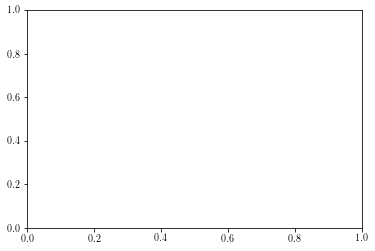

In [44]:
erro_Qc = np.arange(-100,250)
plt.plot(Q_c,np.array(Qc_rg)/16,'o')
plt.plot(erro_Qc,1.1*erro_Qc,'k--')
plt.plot(erro_Qc,0.9*erro_Qc,'k--')
plt.grid()
plt.ylabel('Analytical Cooling Capacity [W]')
plt.xlabel('Numerical Cooling Capacity [W]')
plt.xlim(100,250)
plt.ylim(100,250)
plt.savefig('Qc_fit.png',format = 'png', dpi=500,bbox_inches='tight')

In [ ]:
erro_Qh = np.arange(-100,350)
plt.plot(Q_h,np.array(Qh_rg)/16,'o')
plt.plot(erro_Qh,1.1*erro_Qh,'k--')
plt.plot(erro_Qh,0.9*erro_Qh,'k--')
plt.grid()
plt.ylabel('Analytical Rejected Heat [W]')
plt.xlabel('Numerical Rejected Heat [W]')
plt.xlim(120,300)
plt.ylim(120,300)
plt.savefig('Qh_fit.png',format = 'png', dpi=500,bbox_inches='tight')

In [ ]:
erro_Wp = np.arange(0,25)
plt.plot(W_p,W_pump_rg,'o')

plt.plot(erro_Wp,1.1*erro_Wp,'k--')
plt.plot(erro_Wp,0.9*erro_Wp,'k--')
plt.grid()
plt.ylabel('Analytical Pumping Power [W]')
plt.xlabel('Numerical Pumping Power [W]')
#plt.xlim(120,300)
#plt.ylim(120,300)

### Closure Relations

In [ ]:
plt.plot(N_r,R4,'o')

In [ ]:
plt.plot(H,np.array(R3)-np.array(R2),'o')

Regenerator arranges